In [1]:
import pandas as pd
Y = pd.read_csv("/kaggle/input/nk-sec/Y_train_call.csv")
X = pd.read_csv("/kaggle/input/nk-sec/X_test.csv")

Y.insert(0, 'underlying', X['underlying'])

In [2]:
Y.head()

,underlying,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,...,call_iv_25100,call_iv_25200,call_iv_25300,call_iv_25400,call_iv_25500,call_iv_25600,call_iv_25700,call_iv_25800,call_iv_25900,call_iv_26000
0,24735.9,0.206374,0.198248,0.190741,0.182519,0.175120,0.168219,0.161882,0.156577,0.151857,...,0.161032,0.166277,0.172379,0.178936,0.185562,0.192625,0.199602,0.207571,0.216082,0.225504
1,24766.7,0.205937,0.197908,0.190014,0.182705,0.175091,0.168580,0.161722,0.157152,0.152069,...,0.160960,0.166360,0.172463,0.179000,0.185393,0.192350,0.199239,0.207254,0.216082,0.225284
2,24896.9,0.206817,0.197678,0.191852,0.183050,0.175499,0.168531,0.162125,0.156902,0.151961,...,0.160908,0.166076,0.172182,0.178611,0.185162,0.192070,0.199018,0.206936,0.215692,0.224789
3,24898.1,0.205202,0.198693,0.190968,0.182428,0.175194,0.168518,0.161966,0.156790,0.151924,...,0.160594,0.165921,0.171969,0.178479,0.185017,0.192017,0.198979,0.206756,0.215640,0.224846
4,24906.5,0.206339,0.198076,0.190866,0.182062,0.175398,0.168478,0.161900,0.156876,0.152012,...,0.160524,0.165774,0.171890,0.178367,0.184750,0.191803,0.198778,0.206553,0.215271,0.224846


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class PolynomialModel:
    """Polynomial model for fitting implied volatility smiles."""

    @staticmethod
    def polynomial_func(x, coeffs):
        """Calculates polynomial value for given x and coefficients."""
        y = np.zeros_like(x, dtype=np.float64)
        for i, c in enumerate(coeffs):
            y += c * (x ** i)
        return y

    @staticmethod
    def fit_polynomial(strikes_or_log_moneyness, ivs, degree=4):
        """
        Fits a polynomial of a given degree to the IV data.
        Returns polynomial coefficients and RMSE.
        Input can be strikes or log-moneyness.
        """
        x_data = np.asarray(strikes_or_log_moneyness)
        ivs_data = np.asarray(ivs)

        if len(x_data) < degree + 1:
            return None, 1e10

        try:
            coeffs_polyfit = np.polyfit(x_data, ivs_data, degree)
            coeffs_standard_order = coeffs_polyfit[::-1]

            fitted_ivs = PolynomialModel.polynomial_func(x_data, coeffs_standard_order)
            
            if np.any(np.isnan(fitted_ivs)):
                return None, 1e10

            mse = np.mean((ivs_data - fitted_ivs)**2)
            rmse = np.sqrt(mse)

            return coeffs_standard_order.tolist(), float(rmse)

        except Exception as e:
            return None, 1e10


class PolynomialSmileFitter:
    """Polynomial-focused smile curve fitting with parameter storage."""
    def __init__(self, time_to_expiry=7/365, poly_degree=4):
        self.T = time_to_expiry
        self.poly_degree = poly_degree
        self.underlying_col_name = 'underlying'

    def fit_and_store_parameters(self, df, underlying_col='underlying'):
        self.underlying_col_name = underlying_col 
        
        print(f"🚀 Polynomial Smile Curve Fitting (Degree {self.poly_degree})")
        print("=" * 70)
        
        result_df = df.copy()
        param_columns = [f'poly_c{i}' for i in range(self.poly_degree + 1)] + ['poly_rmse', 'poly_success']
        for col in param_columns:
            result_df[col] = np.nan
            
        successful_fits = 0
        total_curves_attempted = 0
        all_rmses = []
        
        print(f"📊 Processing {len(df)} rows using CPU backend.")
        
        for idx, row in df.iterrows():
            current_underlying_price = row[self.underlying_col_name]
            iv_columns = [col for col in df.columns if col.startswith('call_iv_')]
            
            strikes_list, ivs_list = [], []
            for col in iv_columns:
                strike_str = col.replace('call_iv_', '')
                try:
                    strike = float(strike_str)
                    iv = row[col]
                    if pd.notna(iv) and iv > 1e-5:
                        strikes_list.append(strike)
                        ivs_list.append(iv)
                except ValueError: continue
            
            if len(strikes_list) >= self.poly_degree + 1:
                total_curves_attempted += 1
                strikes_np_arr = np.array(strikes_list)
                ivs_np_arr = np.array(ivs_list)
                log_moneyness_np_arr = np.log(strikes_np_arr / current_underlying_price)

                try:
                    poly_coeffs, poly_rmse = PolynomialModel.fit_polynomial(
                        log_moneyness_np_arr, ivs_np_arr, degree=self.poly_degree
                    )
                    
                    if poly_coeffs is not None and poly_rmse is not None and poly_rmse < 1e9:
                        for i_coeff, coeff_val in enumerate(poly_coeffs):
                            result_df.loc[idx, f'poly_c{i_coeff}'] = coeff_val
                        result_df.loc[idx, 'poly_rmse'] = poly_rmse
                        result_df.loc[idx, 'poly_success'] = True
                        successful_fits += 1
                        all_rmses.append(poly_rmse)
                        
                        if successful_fits > 0 and successful_fits % 100 == 0:
                            current_avg_rmse = np.mean(all_rmses) if all_rmses else float('nan')
                            print(f"✅ Processed {successful_fits} successful polynomial fits (attempted: {total_curves_attempted}) | Avg RMSE: {current_avg_rmse:.6f}")
                    else:
                        result_df.loc[idx, 'poly_success'] = False
                except Exception:
                    result_df.loc[idx, 'poly_success'] = False
            else:
                result_df.loc[idx, 'poly_success'] = False

        avg_rmse_val, median_rmse_val, min_rmse_val, max_rmse_val = np.nan, np.nan, np.nan, np.nan
        success_rate = 0.0
        if total_curves_attempted > 0:
            success_rate = (successful_fits / total_curves_attempted) * 100
        if all_rmses:
            avg_rmse_val = np.mean(all_rmses)
            median_rmse_val = np.median(all_rmses)
            min_rmse_val = np.min(all_rmses)
            max_rmse_val = np.max(all_rmses)
        
        print(f"\n📈 Final Polynomial Fitting Summary (Degree {self.poly_degree}):")
        print(f"{'Total Rows Processed:':<28} {len(df)}")
        print(f"{'Total Curves Attempted:':<28} {total_curves_attempted}")
        print(f"{'Successful Fits:':<28} {successful_fits}")
        print(f"{'Success Rate (on attempts):':<28} {success_rate:.1f}%")

        if all_rmses:
            print(f"{'Average RMSE (successful):':<28} {avg_rmse_val:.6f}")
            print(f"{'Median RMSE (successful):':<28} {median_rmse_val:.6f}")
            print(f"{'Best RMSE (successful):':<28} {min_rmse_val:.6f}")
            print(f"{'Worst RMSE (successful):':<28} {max_rmse_val:.6f}")
            target_rmse_info = 0.001
            if not np.isnan(min_rmse_val) and min_rmse_val < target_rmse_info:
                 print(f"🎯 Best IV RMSE ({min_rmse_val:.6f}) is good.")
            elif not np.isnan(min_rmse_val) :
                 print(f"🎯 Best IV RMSE: {min_rmse_val:.6f}.")
        else:
            print("\n📉 No successful polynomial fits to report detailed RMSE statistics.")
            
        return result_df, {
            'total_curves_attempted': total_curves_attempted,
            'successful_fits': successful_fits,
            'avg_rmse': avg_rmse_val if all_rmses else None,
            'min_rmse': min_rmse_val if all_rmses else None,
            'all_rmses': all_rmses
        }

    def visualize_best_fits(self, df_with_params, n_plots=6):
        successful_fits_df = df_with_params[df_with_params['poly_success'] == True].copy()
        if successful_fits_df.empty:
            print("No successful polynomial fits to visualize.")
            return
        successful_fits_df['poly_rmse'] = pd.to_numeric(successful_fits_df['poly_rmse'], errors='coerce')
        successful_fits_df.dropna(subset=['poly_rmse'], inplace=True)
        if successful_fits_df.empty:
            print("No valid RMSE values in successful polynomial fits to visualize.")
            return

        best_fits_df = successful_fits_df.nsmallest(min(n_plots, len(successful_fits_df)), 'poly_rmse')
        if best_fits_df.empty:
            print("Not enough successful polynomial fits to visualize.")
            return

        n_actual_plots = len(best_fits_df)
        ncols = min(3, n_actual_plots) if n_actual_plots > 0 else 1
        nrows = (n_actual_plots + ncols - 1) // ncols if n_actual_plots > 0 else 1
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6 * nrows), squeeze=False)
        axes_flat = axes.flatten()

        for i, (idx, row) in enumerate(best_fits_df.iterrows()):
            ax = axes_flat[i]
            underlying_val = row[self.underlying_col_name] 
            iv_cols = [col for col in df_with_params.columns if col.startswith('call_iv_')]
            
            strikes_market_l, ivs_market_l = [], []
            for col_name in iv_cols:
                strike_val_str = col_name.replace('call_iv_', '')
                try:
                    s_val = float(strike_val_str)
                    iv_val = row[col_name]
                    if pd.notna(iv_val) and iv_val > 1e-5:
                        strikes_market_l.append(s_val)
                        ivs_market_l.append(iv_val)
                except ValueError: continue
            
            strikes_market_np = np.array(strikes_market_l)
            ivs_market_np = np.array(ivs_market_l)
            if len(strikes_market_np) == 0: continue
            
            log_moneyness_market_np = np.log(strikes_market_np / underlying_val)

            poly_coeffs_plot = [row[f'poly_c{j}'] for j in range(self.poly_degree + 1)]
            
            ax.scatter(log_moneyness_market_np, ivs_market_np, c='black', s=50, label='Market IV', zorder=5, alpha=0.7)
            
            min_log_m_plot = log_moneyness_market_np.min() - 0.1
            max_log_m_plot = log_moneyness_market_np.max() + 0.1
            plot_log_moneyness_np = np.linspace(min_log_m_plot, max_log_m_plot, 200)
            
            fitted_ivs_plot_np = PolynomialModel.polynomial_func(plot_log_moneyness_np, poly_coeffs_plot)

            ax.plot(plot_log_moneyness_np, fitted_ivs_plot_np, 'blue', linewidth=2.0,
                    label=f'Poly Fit (RMSE: {row["poly_rmse"]:.6f})')
            
            ax.set_title(f'Row Idx: {idx}, U: {underlying_val:.2f} | Rank: #{i+1}', fontsize=10)
            ax.set_xlabel('Log-Moneyness k = log(S/F)', fontsize=9)
            ax.set_ylabel('Implied Volatility', fontsize=9)
            ax.legend(fontsize=8); ax.grid(True, linestyle='--', alpha=0.5)
            ax.tick_params(axis='both', which='major', labelsize=8)
            
            coeffs_text_list = [f'c{j}={poly_coeffs_plot[j]:.3e}' for j in range(len(poly_coeffs_plot))]
            coeffs_text = '\n'.join(coeffs_text_list)
            ax.text(0.02, 0.98, coeffs_text, transform=ax.transAxes, fontsize=7,
                    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcyan', alpha=0.7))

        for j in range(n_actual_plots, nrows * ncols): fig.delaxes(axes_flat[j])
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle(f'Best Polynomial (Degree {self.poly_degree}) Smile Fits', fontsize=16, fontweight='bold')
        plt.show()

def run_polynomial_fitting(df, n_samples=None, time_to_expiry=7/365, underlying_col='underlying', poly_degree=4):
    df_to_process = df.copy()
    if n_samples is not None and 0 < n_samples < len(df):
        df_to_process = df.sample(n=n_samples, random_state=42) 
        print(f"Processing a random sample of {len(df_to_process)} rows for polynomial fitting...")
    elif n_samples == 0:
        print(f"Processing 0 rows as per n_samples=0.")
        df_to_process = df.head(0)
    else:
        print(f"Processing all {len(df_to_process)} rows for polynomial fitting...")
    
    if df_to_process.empty:
        print("No data to process.")
        poly_cols = [f'poly_c{i}' for i in range(poly_degree + 1)] + ['poly_rmse', 'poly_success']
        empty_res_df_cols = df.columns.tolist() + [col for col in poly_cols if col not in df.columns]
        return pd.DataFrame(columns=empty_res_df_cols), \
               {'total_curves_attempted': 0, 'successful_fits': 0, 'avg_rmse': None, 'min_rmse': None, 'all_rmses': []}

    fitter = PolynomialSmileFitter(time_to_expiry=time_to_expiry, poly_degree=poly_degree)
    result_df, stats = fitter.fit_and_store_parameters(df_to_process, underlying_col=underlying_col)
    
    if stats['successful_fits'] > 0:
        print("\n📊 Generating visualizations of best polynomial fits...")
        fitter.visualize_best_fits(result_df, n_plots=min(6, stats['successful_fits']))
    else:
        print("\nℹ️ No successful polynomial fits to visualize.")
    return result_df, stats

Processing all 138577 rows for polynomial fitting...
🚀 Polynomial Smile Curve Fitting (Degree 4)
📊 Processing 138577 rows using GPU (CuPy) backend.
✅ Processed 100 successful polynomial fits (attempted: 100) | Avg RMSE: 0.000947
✅ Processed 200 successful polynomial fits (attempted: 200) | Avg RMSE: 0.000941
✅ Processed 300 successful polynomial fits (attempted: 300) | Avg RMSE: 0.000925
✅ Processed 400 successful polynomial fits (attempted: 400) | Avg RMSE: 0.000916
✅ Processed 500 successful polynomial fits (attempted: 500) | Avg RMSE: 0.000927
✅ Processed 600 successful polynomial fits (attempted: 600) | Avg RMSE: 0.000934
✅ Processed 700 successful polynomial fits (attempted: 700) | Avg RMSE: 0.000936
✅ Processed 800 successful polynomial fits (attempted: 800) | Avg RMSE: 0.000938
✅ Processed 900 successful polynomial fits (attempted: 900) | Avg RMSE: 0.000951
✅ Processed 1000 successful polynomial fits (attempted: 1000) | Avg RMSE: 0.000954
✅ Processed 1100 successful polynomial f

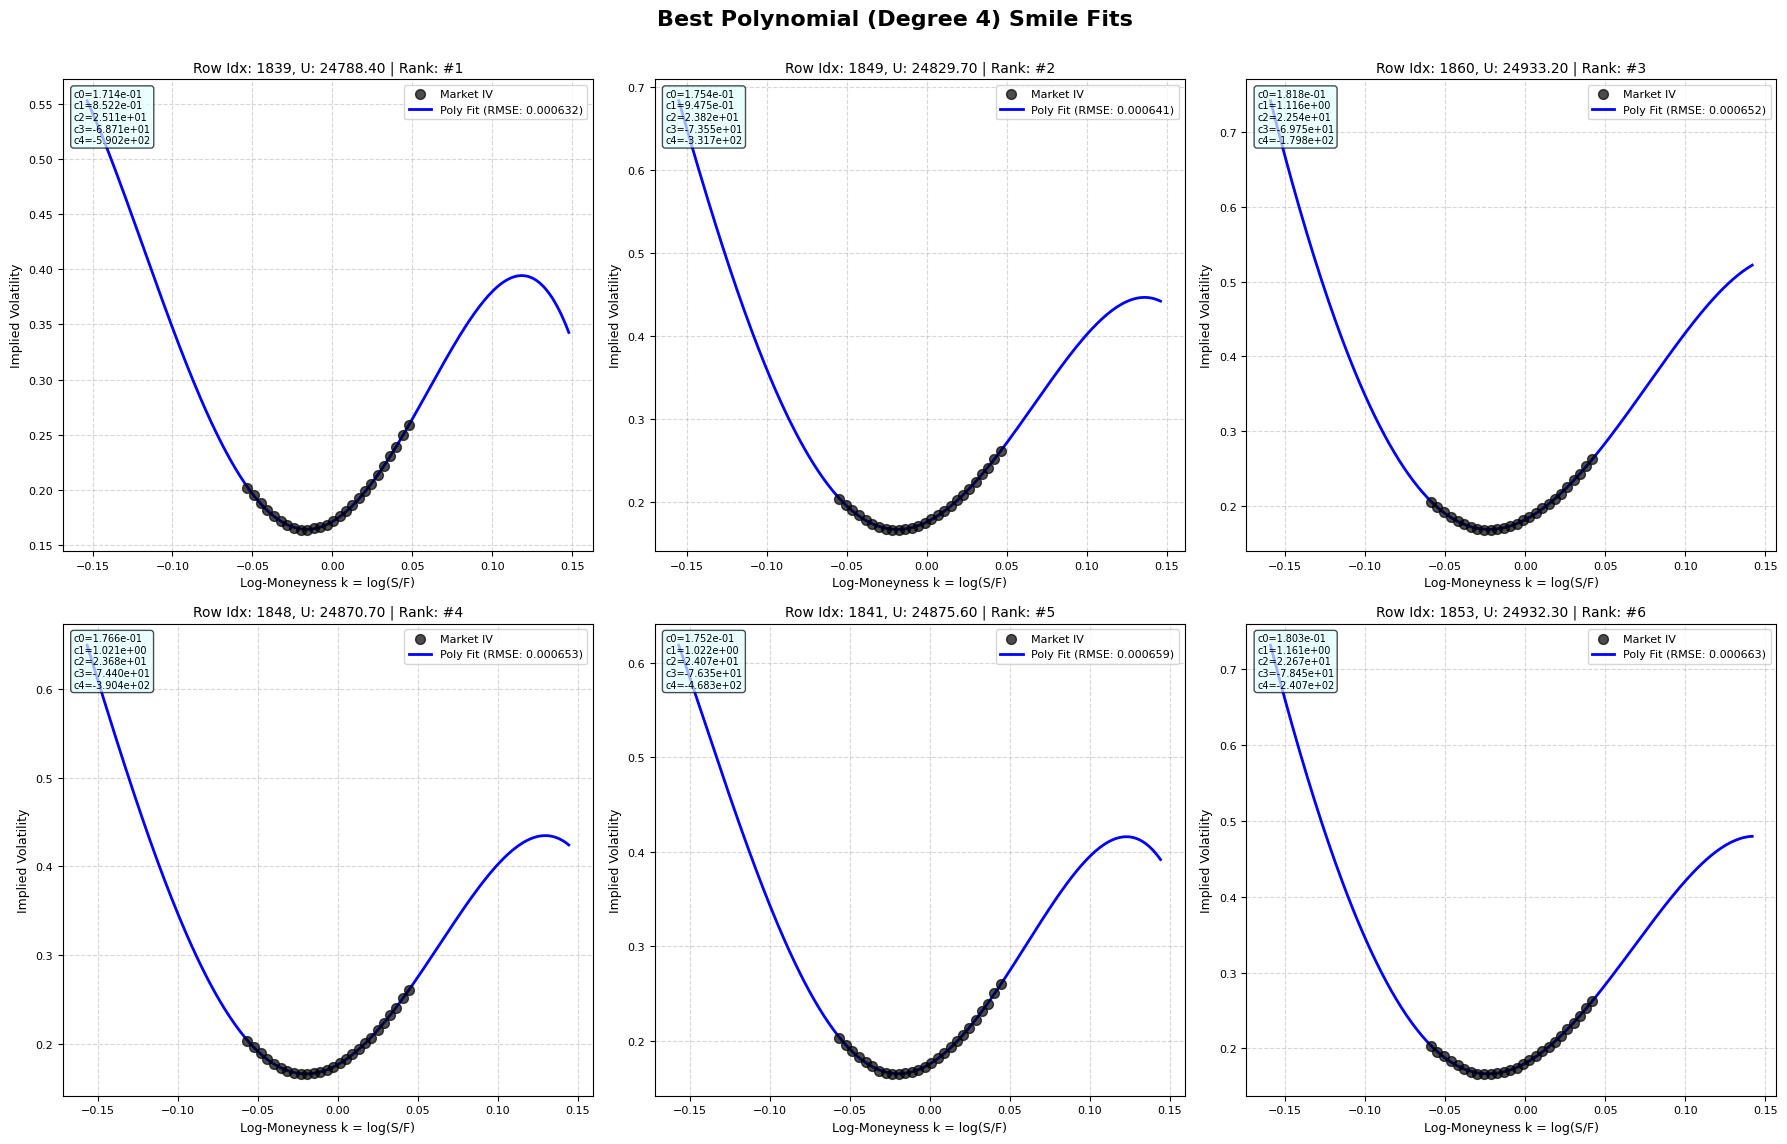

In [7]:
params_call, stats = run_polynomial_fitting(Y, Y.shape[0])